# Bilayer Sonophore model: pre-computation of intermolecular pressure

Profiled simulations of the mechanical model in isolation reveal that the spatial integration of intermolecular pressure $P_M$ is by far the longest internal computation at each iteration. Hence, we seek to decrease its computational cost.

Luckily, despite its complexity, this integrated pressure term depends solely on leaflet deflection and the nature of its profile is similar to that of its local counterpart.

Therefore, a precomputing step is defined wherein a Lennard-Jones expression of the form:

$\tilde{P_M}(Z)= \tilde{A_r} \big[ \big(\frac{\tilde{\Delta^*}}{2 \cdot Z + \Delta(Q_m)}\big)^\tilde{x} - \big(\frac{\tilde{\Delta^*}}{2 \cdot Z + \Delta(Q_m)}\big)^\tilde{y} \big]$

is fitted to the integrated profile and then used as a new predictor of intermolecular pressure during the iterative numerical resolution.

### Imports

In [1]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.utils import logger, rmse, rsquared
from PySONIC.neurons import getPointNeuron
from PySONIC.core import BilayerSonophore, PmCompMethod, AcousticDrive
from PySONIC.constants import *

# Set logging level
logger.setLevel(logging.INFO)

### Functions

In [10]:
def plotPmavg(bls, Z, fs=15):
    fig, ax = plt.subplots(figsize=(5, 3))
    for skey in ['right', 'top']:
        ax.spines[skey].set_visible(False)
    ax.set_xlabel('Z (nm)', fontsize=fs)
    ax.set_ylabel('Pressure (kPa)', fontsize=fs)
    ax.set_xticks([0, bls.a * 1e9])
    ax.set_xticklabels(['0', 'a'])
    ax.set_yticks([-10, 0, 40])
    ax.set_ylim([-10, 50])
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)
    ax.plot(Z * 1e9, bls.v_PMavg(Z, bls.v_curvrad(Z), bls.surface(Z)) * 1e-3, label='$P_m$')
    ax.plot(Z * 1e9, bls.PMavgpred(Z) * 1e-3, label='$P_{m,approx}$')
    ax.axhline(y=0, color='k')
    ax.legend(fontsize=fs, frameon=False)
    fig.tight_layout()

def plotZprofiles(bls, US_source, Q, fs=15):
    # Run simulations with integrated and predicted intermolecular pressure
    t0 = time.perf_counter()
    data1, _ = bls.simulate(US_source, Qm, Pm_comp_method=PmCompMethod.direct)
    tcomp_direct = time.perf_counter() - t0
    print(f'computation time with direct Pm: {tcomp_direct} s')
    Z1 = data1['Z'].values[-NPC_DENSE:] * 1e9  # nm
    
    t0 = time.perf_counter()
    data2, _ = bls.simulate(US_source, Qm, Pm_comp_method=PmCompMethod.predict)
    tcomp_predict = time.perf_counter() - t0
    print(f'computation time with predicted Pm: {tcomp_predict} s')
    Z2 = data2['Z'].values[-NPC_DENSE:] * 1e9  # nm
   
    tcomp_ratio = tcomp_direct / tcomp_predict
    
    # Plot figure    
    t = np.linspace(0, US_source.periodicity, US_source.nPerCycle) * 1e6  # us
    fig, ax = plt.subplots(figsize=(5, 3))
    for skey in ['right', 'top']:
        ax.spines[skey].set_visible(False)
    ax.set_xlabel('time (us)', fontsize=fs)
    ax.set_ylabel('Deflection (nm)', fontsize=fs)
    ax.set_xticks([t[0], t[-1]])
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)
    
    ax.plot(t, Z1, label='$P_m$')
    ax.plot(t, Z2, label='$P_{m,approx}$')
    ax.axhline(y=0, color='k')
    ax.legend(fontsize=fs, frameon=False)
    fig.tight_layout()
    
    return fig, Z1, Z2, tcomp_ratio

### Parameters

In [11]:
pneuron = getPointNeuron('RS')
bls = BilayerSonophore(32e-9, pneuron.Cm0, pneuron.Qm0)
US_source = AcousticDrive(500e3, 100e3)
Qm = pneuron.Qm0

### Profiles comparison over deflection range 

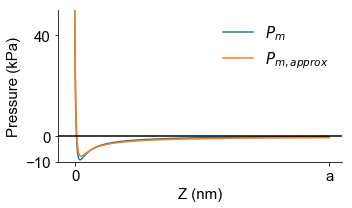

In [12]:
Z = np.linspace(-0.4 * bls.Delta_, bls.a, 1000)
fig = plotPmavg(bls, Z)

### Error quantification over a typical acoustic cycle

 30/01/2020 17:15:24: BilayerSonophore(32.0 nm): simulation @ f = 500.00 kHz, A = 100.00 kPa, Q = -71.90 nC/cm2


computation time with direct Pm: 12.703268000000008 s


 30/01/2020 17:15:36: BilayerSonophore(32.0 nm): simulation @ f = 500.00 kHz, A = 100.00 kPa, Q = -71.90 nC/cm2


computation time with predicted Pm: 1.3662477000000024 s
Z-error: R2 = 0.9996, RMSE = 0.0454 nm (0.8212% dZ)
computational boost: 9.3-fold


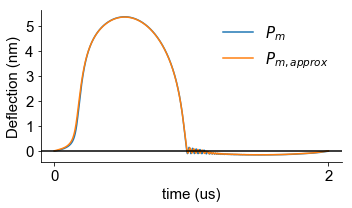

In [13]:
fig, Z1, Z2, tcomp_ratio = plotZprofiles(bls, US_source, Qm)
error_Z = rmse(Z1, Z2)
r2_Z = rsquared(Z1, Z2)
err_pct = error_Z / (Z1.max() - Z1.min()) * 1e2
print(f'Z-error: R2 = {r2_Z:.4f}, RMSE = {error_Z:.4f} nm ({err_pct:.4f}% dZ)')
print(f'computational boost: {tcomp_ratio:.1f}-fold')

As we can see, this simplification allows to reduce computation times by more than one order of magnitude, without significantly affecting the resulting deflection profiles.